In [1]:
import os
import glob
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Model
from tensorflow.keras.utils import to_categorical
from keras.layers import Activation, Input, Conv2D, Add, Flatten, AveragePooling2D, Dense, Dropout, BatchNormalization
from keras.utils.vis_utils import plot_model
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
import h5py

In [2]:
data_dir=os.path.join('dataset')
paths_train_a=glob.glob(os.path.join(data_dir,'training-a','*.png'))
paths_train_b=glob.glob(os.path.join(data_dir,'training-b','*.png'))
paths_train_e=glob.glob(os.path.join(data_dir,'training-e','*.png'))
paths_train_c=glob.glob(os.path.join(data_dir,'training-c','*.png'))
paths_train_d=glob.glob(os.path.join(data_dir,'training-d','*.png'))
paths_train_all=paths_train_a+paths_train_b+paths_train_c+paths_train_d+paths_train_e

paths_test_a=glob.glob(os.path.join(data_dir,'testing-all-corrected','testing-a','*.png'))
paths_test_b=glob.glob(os.path.join(data_dir,'testing-all-corrected','testing-b','*.png'))
paths_test_e=glob.glob(os.path.join(data_dir,'testing-all-corrected','testing-e','*.png'))
paths_test_c=glob.glob(os.path.join(data_dir,'testing-all-corrected','testing-c','*.png'))
paths_test_d=glob.glob(os.path.join(data_dir,'testing-all-corrected','testing-d','*.png'))
paths_test_f=glob.glob(os.path.join(data_dir,'testing-all-corrected','testing-f','*.png'))+glob.glob(os.path.join(data_dir,'testing-f','*.JPG'))
paths_test_auga=glob.glob(os.path.join(data_dir,'testing-all-corrected','testing-auga','*.png'))
paths_test_augc=glob.glob(os.path.join(data_dir,'testing-all-corrected','testing-augc','*.png'))
paths_test_all=paths_test_a+paths_test_b+paths_test_c+paths_test_d+paths_test_e+paths_test_f+paths_test_auga+paths_test_augc

path_label_train_a=os.path.join(data_dir,'training-a.csv')
path_label_train_b=os.path.join(data_dir,'training-b.csv')
path_label_train_e=os.path.join(data_dir,'training-e.csv')
path_label_train_c=os.path.join(data_dir,'training-c.csv')
path_label_train_d=os.path.join(data_dir,'training-d.csv')

In [3]:
paths_train_all

['dataset\\training-a\\a00000.png',
 'dataset\\training-a\\a00001.png',
 'dataset\\training-a\\a00002.png',
 'dataset\\training-a\\a00003.png',
 'dataset\\training-a\\a00004.png',
 'dataset\\training-a\\a00005.png',
 'dataset\\training-a\\a00006.png',
 'dataset\\training-a\\a00007.png',
 'dataset\\training-a\\a00008.png',
 'dataset\\training-a\\a00009.png',
 'dataset\\training-a\\a00010.png',
 'dataset\\training-a\\a00011.png',
 'dataset\\training-a\\a00012.png',
 'dataset\\training-a\\a00013.png',
 'dataset\\training-a\\a00014.png',
 'dataset\\training-a\\a00015.png',
 'dataset\\training-a\\a00016.png',
 'dataset\\training-a\\a00017.png',
 'dataset\\training-a\\a00018.png',
 'dataset\\training-a\\a00019.png',
 'dataset\\training-a\\a00020.png',
 'dataset\\training-a\\a00021.png',
 'dataset\\training-a\\a00022.png',
 'dataset\\training-a\\a00023.png',
 'dataset\\training-a\\a00024.png',
 'dataset\\training-a\\a00025.png',
 'dataset\\training-a\\a00026.png',
 'dataset\\training-a\\a0002

In [4]:
FIG_WIDTH=20 
HEIGHT_PER_ROW=3 
ROW_HEIGHT=3 
RESIZE_DIM=28

In [5]:
def get_key(path):
    # seperates the key of an image from the filepath
    key=path.split(sep=os.sep)[-1]
    return key

def get_data(paths_img,path_label=None,resize_dim=None):

    X=[] # initialize empty list for resized images
    for i,path in enumerate(paths_img):
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE) # images loaded in color (BGR)
        if resize_dim is not None:
            img=cv2.resize(img,(resize_dim,resize_dim),interpolation=cv2.INTER_AREA) # resize image to 28x28
#         X.append(np.expand_dims(img,axis=2)) # expand image to 28x28x1 and append to the list.
        X.append(img) # expand image to 28x28x1 and append to the list
        # display progress
        if i==len(paths_img)-1:
            end='\n'
        else: end='\r'
        print('processed {}/{}'.format(i+1,len(paths_img)),end=end)
        
    X=np.array(X) # tranform list to numpy array
    if  path_label is None:
        return X
    else:
        df = pd.read_csv(path_label) # read labels
        df=df.set_index('filename') 
        y_label=[df.loc[get_key(path)]['digit'] for path in  paths_img] # get the labels corresponding to the images
        y=to_categorical(y_label,10) # transfrom integer value to categorical variable
        return X, y

def imshow_group(X,y=None,y_pred=None,n_per_row=10):

    n_sample=len(X)
    img_dim=X.shape[1]
    j=np.ceil(n_sample/n_per_row)
    fig=plt.figure(figsize=(FIG_WIDTH,ROW_HEIGHT*j))
    for i,img in enumerate(X):
        plt.subplot(j,n_per_row,i+1)
        plt.imshow(img)
        if y is not None:
                plt.title('true label: {}'.format(np.argmax(y[i])))
        if y_pred is not None:
            top_n=3 # top 3 predictions with highest probabilities
            ind_sorted=np.argsort(y_pred[i])[::-1]
            h=img_dim+4
            for k in range(top_n):
                string='pred: {} ({:.0f}%)\n'.format(ind_sorted[k],y_pred[i,ind_sorted[k]]*100)
                plt.text(img_dim/2, h, string, horizontalalignment='center',verticalalignment='center')
                h+=4
        plt.axis('off')
    plt.show()
def create_submission(predictions,keys,path):
    result = pd.DataFrame(
        predictions,
        columns=['label'],
        index=keys
        )
    result.index.name='key'
    result.to_csv(path, index=True)

In [6]:
X_train_a,y_train_a=get_data(paths_train_a,path_label_train_a,resize_dim=RESIZE_DIM)
X_train_b,y_train_b=get_data(paths_train_b,path_label_train_b,resize_dim=RESIZE_DIM)
X_train_c,y_train_c=get_data(paths_train_c,path_label_train_c,resize_dim=RESIZE_DIM)
X_train_d,y_train_d=get_data(paths_train_d,path_label_train_d,resize_dim=RESIZE_DIM)
X_train_e,y_train_e=get_data(paths_train_e,path_label_train_e,resize_dim=RESIZE_DIM)

processed 19702/19702
processed 359/359
processed 24298/24298
processed 10908/10908
processed 16778/16778


In [7]:
X_train_all=np.concatenate((X_train_a,X_train_b,X_train_c,X_train_d,X_train_e),axis=0)
y_train_all=np.concatenate((y_train_a,y_train_b,y_train_c,y_train_d,y_train_e),axis=0)
X_train_all.shape, y_train_all.shape

((72045, 28, 28), (72045, 10))

In [8]:
X_test_a=get_data(paths_test_a,resize_dim=RESIZE_DIM)
X_test_b=get_data(paths_test_b,resize_dim=RESIZE_DIM)
X_test_c=get_data(paths_test_c,resize_dim=RESIZE_DIM)
X_test_d=get_data(paths_test_d,resize_dim=RESIZE_DIM)
X_test_e=get_data(paths_test_e,resize_dim=RESIZE_DIM)
X_test_f=get_data(paths_test_f,resize_dim=RESIZE_DIM)
X_test_auga=get_data(paths_test_auga,resize_dim=RESIZE_DIM)
X_test_augc=get_data(paths_test_augc,resize_dim=RESIZE_DIM)

processed 3489/3489
processed 69/69
processed 4381/4381
processed 1948/1948
processed 2970/2970
processed 495/495
processed 2168/2168
processed 2106/2106


In [9]:
X_test_all=np.concatenate((X_test_a,X_test_b,X_test_c,X_test_d,X_test_e,X_test_f,X_test_auga,X_test_augc))
X_show_all=X_train_all

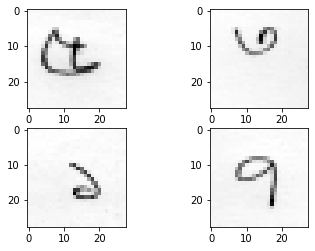

In [10]:
plt.subplot(221)
plt.imshow(X_train_all[0], cmap=plt.get_cmap('gray'))
plt.subplot(222)
plt.imshow(X_train_all[1], cmap=plt.get_cmap('gray'))
plt.subplot(223)
plt.imshow(X_train_all[2], cmap=plt.get_cmap('gray'))
plt.subplot(224)
plt.imshow(X_train_all[3], cmap=plt.get_cmap('gray'))
# show the plot
plt.show()

In [11]:
X_train_all = X_train_all.reshape(X_train_all.shape[0],28, 28,1)
X_test_all = X_test_all.reshape(X_test_all.shape[0],28, 28,1)

In [12]:
X_train_all = X_train_all/255
X_test_all=X_test_all/255

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all, test_size=0.20, random_state=42, shuffle=True)

In [15]:
X_train[0].shape

In [37]:
def blocks(x, strides, filters):
    y = x
    
    x = Conv2D(filters, kernel_size = 3, padding = "same", strides = strides)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    x = Conv2D(filters, kernel_size = 3, padding = "same", strides = (1, 1))(x)
    x = BatchNormalization()(x)
    
    
    if strides[0] > 1:
        y = Conv2D(filters, kernel_size = 3, padding = "same", strides = strides)(y)
        y = BatchNormalization()(y)
        
    x = Add()([x, y])
    return x

In [38]:
def residual_net(input_shape, num_classes, filters, blks):
    inputs = Input(input_shape)
    x = Conv2D(filters, kernel_size = 7, padding = "same", strides = (1, 1))(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # Adding residual blocks
    for block in blks:
        x = blocks(x, strides = (2, 2), filters = filters)
        for i in range(block - 1):
            x = blocks(x, strides = (1, 1), filters = filters)
        filters *= 2
        
    x = AveragePooling2D(4)(x)
    x = Flatten()(x)
    x = Dropout(0.3)(x)
    x = Dense(int(filters/4), activation='relu')(x)
    outputs = Dense(10, activation='softmax')(x)
    
    # Instantiate model
    model = Model(inputs=inputs, outputs=outputs)
    return model       
        

In [41]:
model = residual_net(
    input_shape=X_train[0].shape, 
    num_classes=10, 
    filters=64, 
    blks=[2,2,2]
)
resnet_architecture = plot_model(model, show_shapes=True, show_layer_names=False)
resnet_architecture.width = 600
resnet_architecture

In [48]:
def train(epochs, batch_size, i):
    model = residual_net(
    input_shape=X_train[0].shape, 
    num_classes=10, 
    filters=64, 
    blks=[3,3,3])
    
    model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
    
    checkpoint = ModelCheckpoint(
    filepath=f'resnet-{i}.hdf5',
    monitor='loss',
    save_best_only=True
    )
    def scheduler(epoch):
        return 0.001 * 0.8**epoch
    schedule = LearningRateScheduler(scheduler)
    callbacks = [checkpoint, schedule]
    
    train_datagen = ImageDataGenerator(  
        rotation_range=10,  
        zoom_range=0.1, 
        width_shift_range=0.1, 
        height_shift_range=0.1)
    
    train_datagen.fit(X_train)

    # Fit model
    history = model.fit_generator(
        train_datagen.flow(X_train, y_train, batch_size=batch_size),
        epochs=epochs, 
        verbose=2, 
        callbacks=callbacks)
    
    return history, model

In [49]:
models = []
all_history = []
for i in range(5):
    print("#"*20)
    print(f"Model number {i + 1}")
    print("#"*20)
    
    history, model = train(
        epochs=12,
        batch_size=128, i = i)
    
    models.append(model)
    all_history.append(history)

In [14]:
models = []
resnet_0=keras.models.load_model('results/resnet-0.hdf5')
resnet_1=keras.models.load_model('results/resnet-1.hdf5')
resnet_2=keras.models.load_model('results/resnet-2.hdf5')
resnet_3=keras.models.load_model('results/resnet-3.hdf5')
resnet_4=keras.models.load_model('results/resnet-4.hdf5')
models.append(resnet_0)
models.append(resnet_1)
models.append(resnet_2)
models.append(resnet_3)
models.append(resnet_4)

In [15]:
preds = []
for model in models:
    preds.append(model.predict(X_test_all))

551/551 [==============================] - 73s 132ms/step


In [16]:
pred_labels = []
for pred in preds:
    pred_labels.append([np.argmax(i) for i in pred])

In [18]:
keys=[get_key(path) for path in paths_test_all ]

In [19]:
i = 0
for pred_label in pred_labels:
    create_submission(predictions=pred_label,keys=keys,path='Submissions/submission_resnet_'+str(i)+'.csv')
    i = i+1
    print(i)

1
2
3
4
5


In [20]:
preds = []
for model in models:
    model.evaluate(X_val, y_val)

451/451 [==============================] - 60s 131ms/step - loss: 0.0573 - accuracy: 0.9803


**Prediction score on Test Data:**
- ResNet Model 0 : 0.85347
- ResNet Model 1 : 0.85590
- ResNet Model 2 : 0.84816
- ResNet Model 3 : 0.82183
- ResNet Model 4 : 0.83431